# Neural Networks


## Objective
- Understand neural network basics through a **scratch** implementation.
- Learn how to handle **image data** and train on **MNIST**.


In [1]:
# Imports & reproducibility
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)  # reproducibility

# Matplotlib params preferred
plt.rcParams["figure.figsize"] = (7.0, 5.0)
plt.rcParams["axes.grid"] = True

## 1) Load MNIST

We use Keras (`keras.datasets.mnist`) to download the dataset.


In [2]:
# Load MNIST directly from Keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Dtype:", X_train.dtype)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 28, 28)  Test shape: (10000, 28, 28)
Dtype: uint8


### Inspect a sample image

Image shape: (28, 28) dtype: uint8


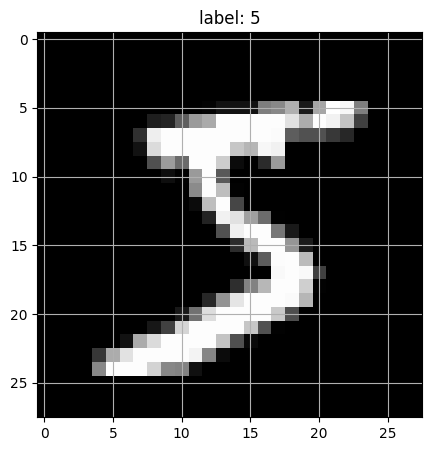

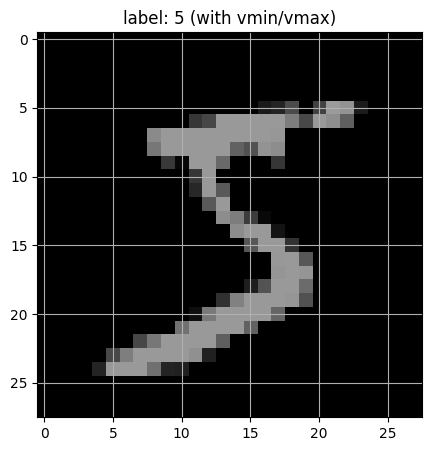

In [3]:
idx = 0
image = X_train[idx]           # (28,28)
print("Image shape:", image.shape, "dtype:", image.dtype)
plt.figure()
plt.imshow(image, cmap="gray")
plt.title(f"label: {y_train[idx]}")
plt.show()

# Optional: demonstrate vmin/vmax to prevent auto scaling surprises
plt.figure()
plt.imshow(image.astype(np.float64) - 100.0, cmap="gray", vmin=0, vmax=255)
plt.title(f"label: {y_train[idx]} (with vmin/vmax)")
plt.show()

## 2) Preprocessing
- **Flatten** images: (N, 28, 28) → (N, 784)
- **Normalize** to `[0,1]` floats
- **One-hot encode** labels for multi-class (10 classes)
- Split training into **train (48k)** and **validation (12k)**.


In [4]:
# Flatten
X_train = X_train.reshape(-1, 784)
X_test  = X_test.reshape(-1, 784)

# Normalize to [0,1] floats
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# One-hot encode labels
try:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))
y_test_onehot  = enc.transform(y_test.reshape(-1, 1))

print("y_train_onehot shape:", y_train_onehot.shape, " dtype:", y_train_onehot.dtype)

# Train/validation split from the 60k training set: 48k / 12k
X_train, X_val, y_train_onehot, y_val_onehot, y_train, y_val = train_test_split(
    X_train, y_train_onehot, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("X_train:", X_train.shape, "  X_val:", X_val.shape)

y_train_onehot shape: (60000, 10)  dtype: float64
X_train: (48000, 784)   X_val: (12000, 784)


## 3) Mini-batch iterator

In [5]:
class GetMiniBatch:
    """Mini-batch iterator"""
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = int(batch_size)
        rng = np.random.default_rng(seed)
        shuffle_index = rng.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0] / self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = p0 + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = p0 + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

_ = GetMiniBatch(X_train, y_train_onehot, batch_size=20, seed=42)
print("Mini-batches per epoch:", len(_))

Mini-batches per epoch: 2400


## 4) Math helpers: activations, softmax, loss, accuracy

In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid_from_act(sig):
    return sig * (1.0 - sig)

def tanh(x):
    return np.tanh(x)

def dtanh_from_act(th):
    return 1.0 - th**2

def softmax_stable(logits):
    shift = logits - logits.max(axis=1, keepdims=True)
    exp = np.exp(shift)
    return exp / exp.sum(axis=1, keepdims=True)

def cross_entropy(y_true_onehot, y_pred_proba, eps=1e-7):
    y_pred_clipped = np.clip(y_pred_proba, eps, 1.0 - eps)
    return -np.mean(np.sum(y_true_onehot * np.log(y_pred_clipped), axis=1))

def accuracy_from_logits(y_true_int, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    return float((y_true_int == y_pred).mean())

## 5) Scratch 3-Layer Neural Network

In [7]:
class ScratchSimpleNeuralNetworkClassifier:
    def __init__(self,
                 n_features=784,
                 n_hidden1=400,
                 n_hidden2=200,
                 n_output=10,
                 activation="tanh",
                 sigma=0.01,
                 lr=0.1,
                 batch_size=20,
                 epochs=10,
                 seed=42,
                 verbose=True):
        self.n_features = n_features
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
        self.activation = activation
        self.sigma = sigma
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.verbose = verbose

        self.train_loss_ = []
        self.val_loss_ = []
        self.train_acc_ = []
        self.val_acc_ = []

        rng = np.random.default_rng(self.seed)
        self.W1 = self.sigma * rng.standard_normal((self.n_features, self.n_hidden1))
        self.b1 = np.zeros(self.n_hidden1, dtype=np.float32)
        self.W2 = self.sigma * rng.standard_normal((self.n_hidden1, self.n_hidden2))
        self.b2 = np.zeros(self.n_hidden2, dtype=np.float32)
        self.W3 = self.sigma * rng.standard_normal((self.n_hidden2, self.n_output))
        self.b3 = np.zeros(self.n_output, dtype=np.float32)

    def _act(self, A):
        if self.activation == "tanh":
            Z = np.tanh(A)
            d_act = 1.0 - Z**2
        elif self.activation == "sigmoid":
            Z = 1.0 / (1.0 + np.exp(-A))
            d_act = Z * (1.0 - Z)
        else:
            raise ValueError("activation must be 'tanh' or 'sigmoid'")
        return Z, d_act

    def _forward(self, X):
        A1 = X @ self.W1 + self.b1
        Z1, dZ1 = self._act(A1)

        A2 = Z1 @ self.W2 + self.b2
        Z2, dZ2 = self._act(A2)

        A3 = Z2 @ self.W3 + self.b3
        Z3 = softmax_stable(A3)

        cache = {"A1": A1, "Z1": Z1, "dZ1": dZ1,
                 "A2": A2, "Z2": Z2, "dZ2": dZ2,
                 "A3": A3, "Z3": Z3}
        return Z3, cache

    def fit(self, X, y_onehot, X_val=None, y_val_onehot=None, y_int=None, y_val_int=None):
        batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=self.seed)
        for epoch in range(self.epochs):
            for Xb, yb in batcher:
                yhat, cache = self._forward(Xb)

                N = Xb.shape[0]
                dA3 = (yhat - yb) / N

                dW3 = cache["Z2"].T @ dA3
                db3 = dA3.sum(axis=0)

                dZ2 = dA3 @ self.W3.T
                dA2 = dZ2 * cache["dZ2"]

                dW2 = cache["Z1"].T @ dA2
                db2 = dA2.sum(axis=0)

                dZ1 = dA2 @ self.W2.T
                dA1 = dZ1 * cache["dZ1"]

                dW1 = Xb.T @ dA1
                db1 = dA1.sum(axis=0)

                self.W3 -= self.lr * dW3
                self.b3 -= self.lr * db3
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1

            yhat_train, _ = self._forward(X)
            train_loss = cross_entropy(y_onehot, yhat_train)
            self.train_loss_.append(train_loss)
            if y_int is not None:
                self.train_acc_.append(accuracy_from_logits(y_int, yhat_train))

            if X_val is not None and y_val_onehot is not None:
                yhat_val, _ = self._forward(X_val)
                val_loss = cross_entropy(y_val_onehot, yhat_val)
                self.val_loss_.append(val_loss)
                if y_val_int is not None:
                    self.val_acc_.append(accuracy_from_logits(y_val_int, yhat_val))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {train_loss:.4f}"
                if self.val_loss_:
                    msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_:
                    msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_:
                    msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self

    def predict_proba(self, X):
        yhat, _ = self._forward(X)
        return yhat

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

## 6) Train & Validate

In [8]:
nn = ScratchSimpleNeuralNetworkClassifier(
    n_features=784, n_hidden1=400, n_hidden2=200, n_output=10,
    activation="tanh", sigma=0.01, lr=0.1,
    batch_size=20, epochs=10, seed=42, verbose=True
)

_ = nn.fit(
    X_train, y_train_onehot,
    X_val=X_val, y_val_onehot=y_val_onehot,
    y_int=y_train, y_val_int=y_val
)

val_proba = nn.predict_proba(X_val)
val_acc = accuracy_from_logits(y_val, val_proba)
print("Validation accuracy:", f"{val_acc:.4f}")

Epoch 1/10 - loss: 0.2648 - val_loss: 0.2771 - acc: 0.9199 - val_acc: 0.9143
Epoch 2/10 - loss: 0.1644 - val_loss: 0.1872 - acc: 0.9500 - val_acc: 0.9444
Epoch 3/10 - loss: 0.1165 - val_loss: 0.1479 - acc: 0.9635 - val_acc: 0.9560
Epoch 4/10 - loss: 0.0882 - val_loss: 0.1281 - acc: 0.9728 - val_acc: 0.9617
Epoch 5/10 - loss: 0.0719 - val_loss: 0.1192 - acc: 0.9776 - val_acc: 0.9640
Epoch 6/10 - loss: 0.0570 - val_loss: 0.1100 - acc: 0.9821 - val_acc: 0.9673
Epoch 7/10 - loss: 0.0444 - val_loss: 0.1027 - acc: 0.9865 - val_acc: 0.9698
Epoch 8/10 - loss: 0.0364 - val_loss: 0.1009 - acc: 0.9887 - val_acc: 0.9708
Epoch 9/10 - loss: 0.0296 - val_loss: 0.1001 - acc: 0.9909 - val_acc: 0.9720
Epoch 10/10 - loss: 0.0228 - val_loss: 0.0978 - acc: 0.9931 - val_acc: 0.9737
Validation accuracy: 0.9737


Based on the 10 epochs, we notice that the loss reduces with epochs, with a final accuracy of >97%

## 7) Learning Curves

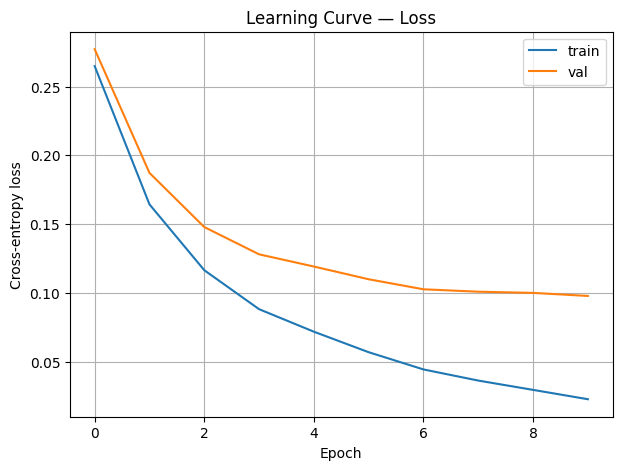

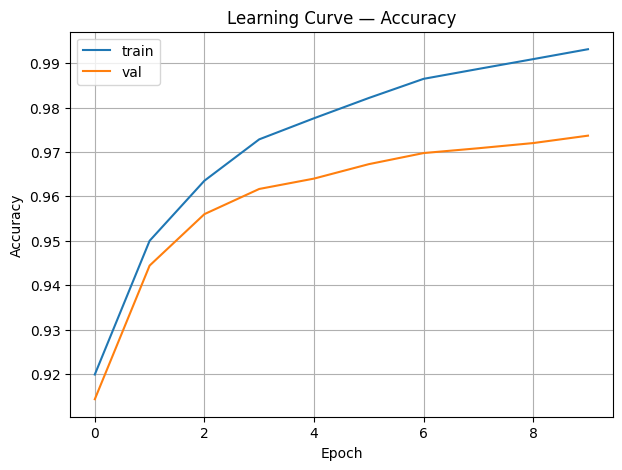

In [9]:
plt.figure()
plt.plot(nn.train_loss_, label="train")
if len(nn.val_loss_) == len(nn.train_loss_):
    plt.plot(nn.val_loss_, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Learning Curve — Loss")
plt.legend()
plt.show()

if nn.train_acc_ and nn.val_acc_:
    plt.figure()
    plt.plot(nn.train_acc_, label="train")
    plt.plot(nn.val_acc_, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve — Accuracy")
    plt.legend()
    plt.show()

## 8) Test Set Evaluation

In [10]:
test_proba = nn.predict_proba(X_test)
test_pred = np.argmax(test_proba, axis=1)
test_acc = float((test_pred == y_test).mean())
print("Test accuracy:", f"{test_acc:.4f}")

Test accuracy: 0.9747


## 9) Misclassified Samples (Advanced)

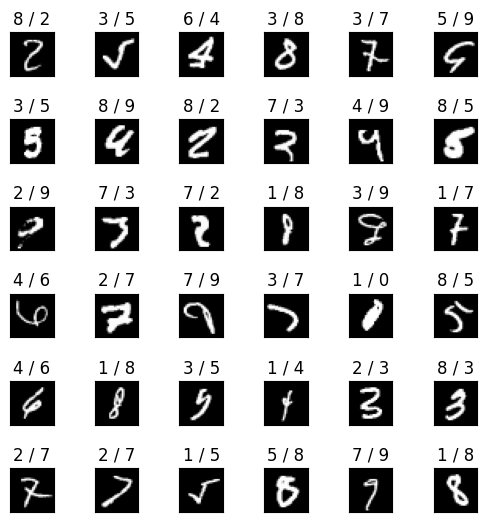

In [11]:
y_pred_val = np.argmax(nn.predict_proba(X_val), axis=1)
num = 36

mismatch = (y_pred_val != y_val)
false_idx = np.where(mismatch)[0].astype(np.int64)

if false_idx.shape[0] == 0:
    print("No misclassifications found on the validation set (nice!).")
else:
    num = min(num, false_idx.shape[0])
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred_val[false_idx[i]], y_val[false_idx[i]]))
        ax.imshow(X_val[false_idx[i]].reshape(28, 28), cmap='gray')
    plt.show()